In [1]:
# Real Data
import os

# Change to the parent directory
os.chdir('../..')

# Verify the path using getcwd()
cwd = os.getcwd()
print("Current working directory:", cwd)


Current working directory: c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import src.file_loader as fl
# import src.sysid_util as sid
import src.data_processing as dp
import src.plotting as plot
import scipy as sp
import control as ct

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker

def plot_voltage(t, y, yhat=None, title="Fit (Truth vs Pred)"):
    plt.figure(figsize=(10, 4))
    plt.plot(t, y[:, 0], label="Truth")
    if yhat is not None:
        plt.plot(t, yhat[:, 0], "--", label="Pred")
    plt.grid(True); plt.legend()
    plt.xlabel("t [s]"); plt.ylabel("V [V]")
    plt.title(title)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))
    ax.ticklabel_format(axis="y", style="plain", useOffset=False)
    plt.tight_layout(); plt.show()


In [4]:
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
import control as ct
from scipy.linalg import block_diag
import matplotlib.ticker as mticker

# =========================================================
# Plot helpers
# =========================================================
def plot_voltage(t, y, yhat=None, title="Voltage"):
    plt.figure(figsize=(10, 4))
    plt.plot(t, y[:, 0], label="Truth")
    if yhat is not None:
        plt.plot(t, yhat[:, 0], "--", label="Pred")
    plt.grid(True); plt.legend()
    plt.xlabel("t [s]"); plt.ylabel("V [V]")
    plt.title(title)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useOffset=False))
    ax.ticklabel_format(axis="y", style="plain", useOffset=False)
    plt.tight_layout(); plt.show()

# =========================================================
# Index map (global)
# =========================================================
IDX = {
    "cn": slice(0, 4),
    "cp": slice(4, 8),
    "ce": slice(8, 14),

    "cn_surf": 3,
    "cp_surf": 7,
    "ce_left": 8,
    "ce_right": 13,
}

# =========================================================
# Unified parameter block
# =========================================================
@dataclass
class Config:
    # Physical constants
    R: float = 8.314462618
    F: float = 96485.33212
    T: float = 298.15
    T_ref: float = 298.15

    # Geometry
    L1: float = 25e-6
    L2: float = 20e-6
    L3: float = 25e-6
    Rn: float = 5e-6
    Rp: float = 5e-6
    A: float = 1.0

    # Transport
    Dn: float = 1e-14
    Dp: float = 1e-14
    De: float = 7.23e-10
    eps: float = 0.30

    # Effective conductivities for R_el
    kappa_n_eff: float = 1.0
    kappa_s_eff: float = 1.0
    kappa_p_eff: float = 1.0

    # Kinetics / active surface
    a_s_n: float = 1.0e6
    a_s_p: float = 1.0e6
    k_n0: float = 2.0e-11
    k_p0: float = 2.0e-11
    use_arrhenius: bool = False
    Ea_n: float = 0.0
    Ea_p: float = 0.0

    # LAM (optional)
    lam_n: float = 0.0
    lam_p: float = 0.0

    # Capacity-scale (stoichiometries)
    csn_max: float = 3.1e4
    csp_max: float = 3.1e4

    # Electrolyte & electrical
    ce0: float = 1000.0
    t_plus: float = 0.38
    k_f: float = 1.0
    R_ohm: float = 0.0
    use_dynamic_film: bool = False
    Rf: float = 0.0
    L_sei: float = 0.0
    kappa_sei: float = 1.0

    # Flags & conventions
    ce_is_deviation: bool = True
    discharge_positive: bool = False # I changed it now
    ln_orientation: str = "right_over_left"
    eta_mode: str = "diff"

    # Simulation knobs
    I_dyn: float = 2.0
    I_for_voltage: float = 2.0

    # Numerical guards / stability
    theta_guard: float = 1e-3
    I0_floor_p: float = 1e-2
    I0_floor_n: float = 1e-2
    bv_scale: float = 0.7
    N_series: int = 3

# =========================================================
# Simple OCVs
# =========================================================
def ocp_p(xp: np.ndarray) -> np.ndarray:
    x = np.clip(xp, 1e-9, 1 - 1e-9)
    return 4.15 - 0.12 * np.tanh((x - 0.60) / 0.08)

def ocp_n(xn: np.ndarray) -> np.ndarray:
    x = np.clip(xn, 1e-9, 1 - 1e-9)
    return 0.10 + 0.80 * (1.0 / (1.0 + np.exp(-(x - 0.50) / 0.04)))

# =========================================================
# Solid diffusion blocks (4 nodes)
# =========================================================
def build_An(cfg: Config) -> np.ndarray:
    s = cfg.Dn / (cfg.Rn ** 2)
    A = np.zeros((4, 4))
    A[0, 0], A[0, 1] = -24 * s, 24 * s
    A[1, 0], A[1, 1], A[1, 2] = 16 * s, -40 * s, 24 * s
    A[2, 1], A[2, 2], A[2, 3] = 16 * s, -40 * s, 24 * s
    A[3, 2], A[3, 3] = 16 * s, -16 * s
    return A

def build_Bn(cfg: Config) -> np.ndarray:
    sign = -1.0 if cfg.discharge_positive else +1.0
    b = np.zeros((4, 1))
    b[-1, 0] = sign * (6.0 / cfg.Rn) * (1.0 / (cfg.F * cfg.a_s_n * cfg.A * cfg.L1))
    return b

def build_Ap(cfg: Config) -> np.ndarray:
    s = cfg.Dp / (cfg.Rp ** 2)
    A = np.zeros((4, 4))
    A[0, 0], A[0, 1] = -24 * s, 24 * s
    A[1, 0], A[1, 1], A[1, 2] = 16 * s, -40 * s, 24 * s
    A[2, 1], A[2, 2], A[2, 3] = 16 * s, -40 * s, 24 * s
    A[3, 2], A[3, 3] = 16 * s, -16 * s
    return A

def build_Bp(cfg: Config) -> np.ndarray:
    sign = +1.0 if cfg.discharge_positive else -1.0
    b = np.zeros((4, 1))
    b[-1, 0] = sign * (6.0 / cfg.Rp) * (1.0 / (cfg.F * cfg.a_s_p * cfg.A * cfg.L3))
    return b

# =========================================================
# Electrolyte diffusion block (6 nodes)
# =========================================================
def build_Ae(cfg: Config) -> np.ndarray:
    K = cfg.De / cfg.eps
    Ae = np.zeros((6, 6))
    w_in = lambda L: K * 4.0 / (L ** 2)
    w_intf = lambda La, Lb: K * 16.0 / ((La + Lb) ** 2)

    w11 = w_in(cfg.L1)
    w12 = w_intf(cfg.L1, cfg.L2)
    w23 = w_in(cfg.L2)
    w34 = w_intf(cfg.L2, cfg.L3)
    w45 = w_in(cfg.L3)

    Ae[0, 0] = -(w11);                 Ae[0, 1] = +(w11)
    Ae[1, 0] = +(w11); Ae[1, 1] = -(w11 + w12); Ae[1, 2] = +(w12)
    Ae[2, 1] = +(w12); Ae[2, 2] = -(w12 + w23); Ae[2, 3] = +(w23)
    Ae[3, 2] = +(w23); Ae[3, 3] = -(w23 + w34); Ae[3, 4] = +(w34)
    Ae[4, 3] = +(w34); Ae[4, 4] = -(w34 + w45); Ae[4, 5] = +(w45)
    Ae[5, 4] = +(w45); Ae[5, 5] = -(w45)
    return Ae

def build_Be(cfg: Config) -> np.ndarray:
    b = np.zeros((6, 1))
    sign_left = -1.0 if cfg.discharge_positive else +1.0
    sign_right = +1.0 if cfg.discharge_positive else -1.0
    s1 = sign_left * (1.0 - cfg.t_plus) / (cfg.F * cfg.A * cfg.L1 * cfg.eps)
    s3 = sign_right * (1.0 - cfg.t_plus) / (cfg.F * cfg.A * cfg.L3 * cfg.eps)
    b[0, 0] = s1; b[1, 0] = s1
    b[4, 0] = s3; b[5, 0] = s3
    return b

# =========================================================
# Assembly
# =========================================================
def assemble_system(cfg: Config):
    An = build_An(cfg); Ap = build_Ap(cfg); Ae = build_Ae(cfg)
    Bn = build_Bn(cfg); Bp = build_Bp(cfg); Be = build_Be(cfg)

    Aglob = block_diag(An, Ap, Ae)
    Bglob = np.vstack([Bn, Bp, Be])

    state_names = (
        [f"cn{i}" for i in range(1, 5)]
        + [f"cp{i}" for i in range(1, 5)]
        + [f"ce{i}" for i in range(1, 7)]
    )

    S = ct.ss(Aglob, Bglob, np.eye(Aglob.shape[0]), np.zeros((Aglob.shape[0], 1)))
    return S, Aglob, Bglob, (An, Ap, Ae, Bn, Bp, Be), state_names

# =========================================================
# Helpers
# =========================================================
def make_x0(cfg: Config, theta_n0=0.2, theta_p0=0.9, ce0=0.0):
    x0 = np.zeros(14)
    x0[IDX["cn"]] = float(theta_n0) * cfg.csn_max
    x0[IDX["cp"]] = float(theta_p0) * cfg.csp_max
    x0[IDX["ce"]] = float(ce0)
    return x0

def sanity_checks(cfg: Config, X: np.ndarray):
    xp = X[:, IDX["cp_surf"]] / cfg.csp_max
    xn = X[:, IDX["cn_surf"]] / cfg.csn_max

    ceL_raw = X[:, IDX["ce_left"]]
    ceR_raw = X[:, IDX["ce_right"]]
    ceL = (cfg.ce0 + ceL_raw) if cfg.ce_is_deviation else ceL_raw
    ceR = (cfg.ce0 + ceR_raw) if cfg.ce_is_deviation else ceR_raw

    print("Sanity:")
    print("  xp range:", float(np.min(xp)), float(np.max(xp)))
    print("  xn range:", float(np.min(xn)), float(np.max(xn)))
    print("  ceL min :", float(np.min(ceL)), " ceR min:", float(np.min(ceR)))

# =========================================================
# Kinetics & voltage
# =========================================================
def _arrhenius(k0: float, Ea: float, cfg: Config) -> float:
    if (not cfg.use_arrhenius) or (Ea == 0.0):
        return k0
    return k0 * np.exp(-Ea / cfg.R * (1.0 / cfg.T - 1.0 / cfg.T_ref))

def i0_current_scales(xp: float, xn: float, ceL: float, ceR: float, cfg: Config) -> tuple[float, float]:
    ce_avg = 0.5 * (ceL + ceR)
    ce_avg = float(np.clip(ce_avg, 1e-12, 10.0 * cfg.ce0))

    xp_eff = float(np.clip(xp, cfg.theta_guard, 1.0 - cfg.theta_guard))
    xn_eff = float(np.clip(xn, cfg.theta_guard, 1.0 - cfg.theta_guard))

    Sp = (1.0 - cfg.lam_p) * cfg.a_s_p * cfg.A * cfg.L3
    Sn = (1.0 - cfg.lam_n) * cfg.a_s_n * cfg.A * cfg.L1

    kp = _arrhenius(cfg.k_p0, cfg.Ea_p, cfg)
    kn = _arrhenius(cfg.k_n0, cfg.Ea_n, cfg)

    i0p = cfg.F * kp * cfg.csp_max * np.sqrt(ce_avg) * np.sqrt(xp_eff * (1.0 - xp_eff))
    i0n = cfg.F * kn * cfg.csn_max * np.sqrt(ce_avg) * np.sqrt(xn_eff * (1.0 - xn_eff))

    I0p = max(float(Sp * i0p), cfg.I0_floor_p)
    I0n = max(float(Sn * i0n), cfg.I0_floor_n)
    return I0p, I0n

def electrolyte_log_term(ceL: float, ceR: float, cfg: Config) -> float:
    ceL = max(ceL, 1e-12)
    ceR = max(ceR, 1e-12)
    ln_arg = (ceR / ceL) if (cfg.ln_orientation == "right_over_left") else (ceL / ceR)
    return (2.0 * cfg.R * cfg.T / cfg.F) * (1.0 - cfg.t_plus) * cfg.k_f * np.log(ln_arg)

def electrolyte_resistance(cfg: Config) -> float:
    return (cfg.L1 / cfg.kappa_n_eff + 2.0 * cfg.L2 / cfg.kappa_s_eff + cfg.L3 / cfg.kappa_p_eff) / (2.0 * cfg.A)

def film_resistance(cfg: Config) -> float:
    if cfg.use_dynamic_film and cfg.L_sei > 0.0:
        return cfg.L_sei / (cfg.kappa_sei * cfg.a_s_n * cfg.A * cfg.L1)
    return cfg.Rf

def terminal_voltage(x: np.ndarray, cfg: Config, I: float | None = None, return_terms: bool = False):
    I_use = cfg.I_for_voltage if (I is None) else float(I)

    xp = np.clip(x[IDX["cp_surf"]] / cfg.csp_max, 1e-9, 1 - 1e-9)
    xn = np.clip(x[IDX["cn_surf"]] / cfg.csn_max, 1e-9, 1 - 1e-9)

    Up = float(ocp_p(np.array([xp]))[0])
    Un = float(ocp_n(np.array([xn]))[0])

    ceL_raw = float(x[IDX["ce_left"]])
    ceR_raw = float(x[IDX["ce_right"]])
    ceL = (cfg.ce0 + ceL_raw) if cfg.ce_is_deviation else ceL_raw
    ceR = (cfg.ce0 + ceR_raw) if cfg.ce_is_deviation else ceR_raw

    I0p, I0n = i0_current_scales(xp, xn, ceL, ceR, cfg)
    eta_p = (2.0 * cfg.R * cfg.T / cfg.F) * np.arcsinh(I_use / (2.0 * max(I0p, 1e-20)))
    eta_n = (2.0 * cfg.R * cfg.T / cfg.F) * np.arcsinh(I_use / (2.0 * max(I0n, 1e-20)))

    eta_p *= cfg.bv_scale
    eta_n *= cfg.bv_scale

    eta_combo = (eta_p - eta_n) if (cfg.eta_mode == "diff") else (eta_p + eta_n)
    dphi_e = electrolyte_log_term(ceL, ceR, cfg)
    ohmic = -I_use * (cfg.R_ohm + electrolyte_resistance(cfg) + film_resistance(cfg))

    V_cell = (Up - Un) + eta_combo + dphi_e + ohmic
    V_pack = cfg.N_series * V_cell

    if not return_terms:
        return float(V_pack)

    return float(V_pack), {
        "Up": Up, "Un": Un, "Udiff": Up - Un,
        "eta_p": float(eta_p), "eta_n": float(eta_n), "eta_combo": float(eta_combo),
        "dphi_e": float(dphi_e), "ohmic": float(ohmic), "I_use": float(I_use),
        "xp": float(xp), "xn": float(xn), "ceL": float(ceL), "ceR": float(ceR),
        "I0p": float(I0p), "I0n": float(I0n),
        "R_el": electrolyte_resistance(cfg), "R_film": film_resistance(cfg),
    }

# =========================================================
# Nonlinear IOSystem (truth generator)
# =========================================================

# def battery_update(t, x, u, params):
#     A = params["A"]; B = params["B"]; cfg = params["cfg"]
#     return (A @ x + B[:, 0] * cfg.I_dyn)

def battery_update(t, x, u, params):
    A = params["A"]; B = params["B"]; cfg = params["cfg"]

    # u is empty because inputs=0 in ct.nlsys
    if u is None or (hasattr(u, "size") and u.size == 0):
        I = float(cfg.I_dyn)          # constant-current mode (your current setup)
    else:
        # if later you switch to inputs=1, u will be length-1
        I = float(np.asarray(u).reshape(-1)[0])

    return A @ x + B[:, 0] * I


# def battery_output(t, x, u, params):
#     cfg = params["cfg"]
#     V = terminal_voltage(x, cfg, I=cfg.I_dyn, return_terms=False)
#     return np.hstack([x, V])

def battery_output(t, x, u, params):
    cfg = params["cfg"]

    if u is None or (hasattr(u, "size") and u.size == 0):
        I = float(cfg.I_dyn)
    else:
        I = float(np.asarray(u).reshape(-1)[0])

    V = terminal_voltage(x, cfg, I=I, return_terms=False)
    return np.hstack([x, V])


# def generate_discharge_data(
#     cfg: Config,
#     I_const: float = 2.0,
#     sim_t_end: float = 50,
#     sim_dt: float = 0.1,
#     theta_n0: float = 0.8,
#     theta_p0: float = 0.4,
#     ce0: float = 0.0,
# ):
#     T = np.arange(0.0, sim_t_end + sim_dt, sim_dt)

#     cfg.I_dyn = float(I_const)
#     cfg.I_for_voltage = float(I_const)

#     _, A, B, _, state_names = assemble_system(cfg)
#     nl_params = dict(A=A, B=B, cfg=cfg)

#     battery_nl = ct.nlsys(
#         battery_update, battery_output,
#         name="battery_unified_cfg",
#         params=nl_params,
#         states=state_names,
#         outputs=state_names + ["V_pack_constI"],
#         inputs=0,
#     )
    
#     # battery_nl = ct.nlsys(
#     #     battery_update, battery_output,
#     #     name="battery_unified_cfg",
#     #     params=nl_params,
#     #     states=state_names,
#     #     outputs=state_names + ["V_pack"],
#     #     inputs=1,
#     # )
#     # u = np.full((len(T), 1), I_const)
#     # resp = ct.input_output_response(battery_nl, T, u, X0=x0)

    
    

#     x0 = make_x0(cfg, theta_n0=theta_n0, theta_p0=theta_p0, ce0=ce0)
#     resp = ct.input_output_response(battery_nl, T, 0, X0=x0)

#     X = resp.states.T
#     Y_full = resp.outputs.T
#     V = Y_full[:, -1:]
#     U = np.full((len(T), 1), float(I_const))
#     return T, U, X, V, Y_full




Columns: Index(['flags', 'Ns', 'time/s', 'control/mA', 'Ewe/V', 'I/mA', 'dQ/C',
       '(Q-Qo)/C', 'half cycle', 'Q charge/discharge/mA.h', 'I Range'],
      dtype='object')
Data: 0     0.000000
1    10.000000
2    19.999999
3    29.999999
4    39.999999
Name: time/s, dtype: float64
Columns: Index(['control/mA', 'Ewe/V'], dtype='object')
Data:            control/mA     Ewe/V
time/s                         
0.000000         0.01  0.407403
10.000000        0.01  0.729420
19.999999        0.01  0.746633
29.999999        0.01  0.757071
39.999999        0.01  0.764113


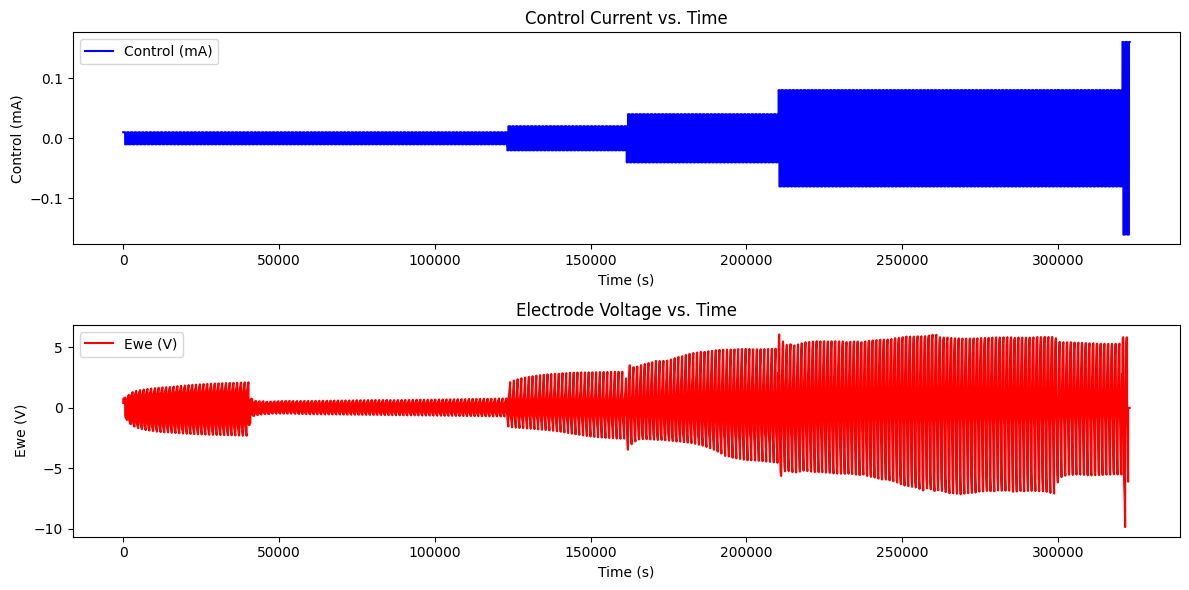

In [5]:
# Load data
mpr_file4 = fl.load_mpr("12to1-25%CNC-3%GQDs _C01.mpr")
df4 = pd.DataFrame(mpr_file4.data)

# Get columns
print("Columns:", df4.columns)
print("Data:", df4['time/s'].head())

df4 = df4.set_index('time/s')[['control/mA', 'Ewe/V']]

print("Columns:", df4.columns)
print("Data:", df4.head())

# Plotting
plt.figure(figsize=(12, 6))

# Plot 'control/mA'
plt.subplot(2, 1, 1)
plt.plot(df4.index, df4['control/mA'], color='blue', label='Control (mA)')
plt.xlabel('Time (s)')
plt.ylabel('Control (mA)')
plt.title('Control Current vs. Time')
plt.legend()

# Plot 'Ewe/V'
plt.subplot(2, 1, 2)
plt.plot(df4.index, df4['Ewe/V'], color='red', label='Ewe (V)')
plt.xlabel('Time (s)')
plt.ylabel('Ewe (V)')
plt.title('Electrode Voltage vs. Time')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [6]:
cycles = dp.find_discharging_cycles(df4)

# Plot the cycles
# plot.plot_cycles(cycles)


In [7]:
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd

def _median_abs(x: np.ndarray) -> float:
    x = np.asarray(x, dtype=np.float64).reshape(-1)
    return float(np.nanmedian(np.abs(x)))

def _sign_fraction(x: np.ndarray, tol: float = 1e-12) -> dict:
    x = np.asarray(x, dtype=np.float64).reshape(-1)
    pos = float(np.mean(x > +tol))
    neg = float(np.mean(x < -tol))
    zer = float(np.mean(np.abs(x) <= tol))
    return {"pos": pos, "neg": neg, "zero": zer}

def _guess_I_in_amps(I_raw: np.ndarray) -> tuple[np.ndarray, str]:
    """
    Heuristic:
      - If median |I_raw| > 5, assume it's mA and convert to A
      - Else assume it's already A
    """
    med = _median_abs(I_raw)
    if med > 5.0:
        return (np.asarray(I_raw, dtype=np.float64) * 1e-3), f"guessed units: mA -> A (median|I_raw|={med:.6g})"
    return (np.asarray(I_raw, dtype=np.float64)), f"guessed units: already A (median|I_raw|={med:.6g})"

def validate_cycle_units_and_sign(
    cycle_df: pd.DataFrame,
    *,
    t_col=None,
    i_col="control/mA",
    v_col="Ewe/V",
    name="cycle",
    tol_I: float = 1e-12
):
    if t_col is None:
        t = np.asarray(cycle_df.index.to_numpy(), dtype=np.float64).reshape(-1)
    else:
        t = np.asarray(cycle_df[t_col].to_numpy(), dtype=np.float64).reshape(-1)

    I_raw = np.asarray(cycle_df[i_col].to_numpy(), dtype=np.float64).reshape(-1)
    V = np.asarray(cycle_df[v_col].to_numpy(), dtype=np.float64).reshape(-1)

    print("\n" + "=" * 80)
    print(f"[VALIDATE] {name}")
    print("=" * 80)

    # describe()
    print("\n[describe] df_cycle[['control/mA','Ewe/V']].describe():")
    print(cycle_df[[i_col, v_col]].describe().to_string())

    # dt stats
    dt = np.diff(t)
    if dt.size > 0:
        print("\n[time] dt stats:")
        print("  median(dt) =", float(np.median(dt)))
        print("  min(dt)    =", float(np.min(dt)))
        print("  max(dt)    =", float(np.max(dt)))
        print("  frac(dt<=0)=", float(np.mean(dt <= 0.0)))
    else:
        print("\n[time] not enough points to compute dt.")

    # median(|I|) before/after conversion
    med_abs_before = _median_abs(I_raw)
    I_A_guess, note = _guess_I_in_amps(I_raw)
    med_abs_after = _median_abs(I_A_guess)
    print("\n[current] median(|I|) before conversion:", med_abs_before)
    print("[current] conversion guess:", note)
    print("[current] median(|I|) after  conversion:", med_abs_after)

    # sign fractions
    frac = _sign_fraction(I_raw, tol=tol_I)
    print("\n[current sign] fraction of samples:")
    print("  pos =", frac["pos"], " neg =", frac["neg"], " zero =", frac["zero"])

    mostly_negative = (frac["neg"] > 0.80) and (frac["pos"] < 0.05)
    mostly_positive = (frac["pos"] > 0.80) and (frac["neg"] < 0.05)

    if mostly_negative:
        print("[current sign] ✅ Current is mostly NEGATIVE (common discharge convention).")
    elif mostly_positive:
        print("[current sign] ✅ Current is mostly POSITIVE (your discharge might be positive).")
    else:
        print("[current sign] ⚠️ Mixed sign current (rest steps / pulses / segmentation issue).")

    print("\n[voltage] min/max:", float(np.min(V)), float(np.max(V)))
    print("=" * 80 + "\n")

    return frac  # <-- useful for downstream decisions


def prepare_cycle_for_sysid(
    cycle_df: pd.DataFrame,
    *,
    t_col=None,
    i_col="control/mA",
    v_col="Ewe/V",
    force_units=None,            # None | "mA" | "A"
    enforce_discharge_only=True, # IMPORTANT: remove the +I samples
    discharge_sign="negative",   # "negative" (Option A) | "positive" (Option B)
    tol_I=1e-6,                  # treat tiny currents as zero-ish
    name="cycle"
):
    """
    Returns t_np (T,), U_np (T,1) [A], Y_np (T,1) [V] for jax_sysid.

    - Validates units/sign and prints stats.
    - If mixed sign and enforce_discharge_only=True, keeps only discharge samples.
    - Can optionally flip sign so discharge is positive everywhere.
    """
    frac = validate_cycle_units_and_sign(
        cycle_df, t_col=t_col, i_col=i_col, v_col=v_col, name=name, tol_I=tol_I
    )

    # Extract
    if t_col is None:
        t = np.asarray(cycle_df.index.to_numpy(), dtype=np.float64).reshape(-1)
    else:
        t = np.asarray(cycle_df[t_col].to_numpy(), dtype=np.float64).reshape(-1)

    I_raw = np.asarray(cycle_df[i_col].to_numpy(), dtype=np.float64).reshape(-1)
    V = np.asarray(cycle_df[v_col].to_numpy(), dtype=np.float64).reshape(-1)

    # Units
    if force_units is None:
        I_A, _ = _guess_I_in_amps(I_raw)
    elif force_units == "mA":
        I_A = I_raw * 1e-3
    elif force_units == "A":
        I_A = I_raw
    else:
        raise ValueError("force_units must be None, 'mA', or 'A'")

    # Rebase time
    t = t - t[0]

    # Enforce strictly increasing time
    keep_time = np.ones_like(t, dtype=bool)
    keep_time[1:] = t[1:] > t[:-1]
    t = t[keep_time]
    I_A = I_A[keep_time]
    V = V[keep_time]

    # If mixed sign, keep only discharge segment (recommended)
    mixed = (frac["pos"] > 0.05) and (frac["neg"] > 0.05)
    if enforce_discharge_only and mixed:
        if discharge_sign == "negative":
            mask = I_A < -tol_I
        elif discharge_sign == "positive":
            mask = I_A > +tol_I
        else:
            raise ValueError("discharge_sign must be 'negative' or 'positive'")

        before_n = len(I_A)
        t = t[mask]
        I_A = I_A[mask]
        V = V[mask]
        print(f"[prepare] Discharge-only filter applied: kept {len(I_A)}/{before_n} samples.")

        # Rebase again after filtering
        if len(t) > 0:
            t = t - t[0]

    # Option B: force discharge to be positive by flipping sign
    if discharge_sign == "positive":
        I_A = -I_A

    # Final shapes
    t_np = t.reshape(-1)
    U_np = I_A.reshape(-1, 1)
    Y_np = V.reshape(-1, 1)

    # Final quick print
    print("[prepare] Final current sign fractions (A):", _sign_fraction(U_np[:, 0], tol=tol_I))
    print("[prepare] U range [A]:", float(U_np.min()), float(U_np.max()))
    print("[prepare] Y range [V]:", float(Y_np.min()), float(Y_np.max()))

    return t_np, U_np, Y_np


# cycle1 = cycles[0].copy()

# t_np, U_np, Y_np = prepare_cycle_for_sysid(
#     cycle1,
#     i_col="control/mA",
#     v_col="Ewe/V",
#     force_units="A",              # your validator shows it's already ~0.01 A
#     enforce_discharge_only=True,  # remove the +I contamination
#     discharge_sign="negative",    # keep discharge negative
#     tol_I=1e-6,
#     name="Cycle 1"
# )

# CFG = Config()
# CFG.N_series = 1
# CFG.discharge_positive = False   # ✅ matches negative discharge current



In [8]:
import numpy as np

# ---- Option A configuration
CFG = Config()
CFG.N_series = 1
CFG.discharge_positive = False  # ✅ Option A: discharge is negative current

cycle1 = cycles[0].copy()

t_np, U_np, Y_np = prepare_cycle_for_sysid(
    cycle1,
    i_col="control/mA",
    v_col="Ewe/V",
    force_units="A",              # because your validator shows ~0.01 already
    enforce_discharge_only=True,  # IMPORTANT: keep only I < 0
    discharge_sign="negative",    # Option A (no sign flip)
    tol_I=1e-6,
    name="Cycle 1"
)

print("Prepared shapes:", t_np.shape, U_np.shape, Y_np.shape)
print("Prepared current range [A]:", float(U_np.min()), float(U_np.max()))
print("Prepared voltage  range [V]:", float(Y_np.min()), float(Y_np.max()))

# Optional: resample to uniform dt for stability
def resample_uniform(t: np.ndarray, u: np.ndarray, y: np.ndarray, dt: float):
    t0, t1 = float(t[0]), float(t[-1])
    tg = np.arange(t0, t1 + dt, dt, dtype=np.float64)
    u1 = np.interp(tg, t, u[:, 0]).reshape(-1, 1)
    y1 = np.interp(tg, t, y[:, 0]).reshape(-1, 1)
    return tg, u1, y1

if len(t_np) >= 3:
    dt_med = float(np.median(np.diff(t_np)))
    # if your dt has weird tiny min spikes, median is fine
    t_np, U_np, Y_np = resample_uniform(t_np, U_np, Y_np, dt=dt_med)

print("After resample shapes:", t_np.shape, U_np.shape, Y_np.shape)
print("dt median:", float(np.median(np.diff(t_np))) if len(t_np) > 2 else None)



def truncate_cycle(
    t_np: np.ndarray,
    U_np: np.ndarray,
    Y_np: np.ndarray,
    *,
    max_points: int = 200,
    max_seconds: float | None = 200.0,
    stride: int = 1
):
    """
    Keep only the early part of the cycle to make fitting fast.
    - max_seconds: keep samples where t <= max_seconds (if not None)
    - max_points: cap number of samples after filtering
    - stride: keep every stride-th sample (downsample)
    """
    t = np.asarray(t_np).reshape(-1)
    U = np.asarray(U_np).reshape(-1, 1)
    Y = np.asarray(Y_np).reshape(-1, 1)

    if len(t) < 2:
        raise ValueError("Need at least 2 samples to truncate.")

    # time window
    if max_seconds is not None:
        mask = t <= float(max_seconds)
        t, U, Y = t[mask], U[mask], Y[mask]

    # stride downsample
    if stride > 1:
        t, U, Y = t[::stride], U[::stride], Y[::stride]

    # point cap
    if len(t) > max_points:
        t, U, Y = t[:max_points], U[:max_points], Y[:max_points]

    # rebase to 0 again
    t = t - t[0]

    # ensure strictly increasing time (paranoia)
    keep = np.ones_like(t, dtype=bool)
    keep[1:] = t[1:] > t[:-1]
    t, U, Y = t[keep], U[keep], Y[keep]

    return t, U, Y

def print_quick_stats(tag, t_np, U_np, Y_np):
    t = np.asarray(t_np).reshape(-1)
    U = np.asarray(U_np).reshape(-1)
    Y = np.asarray(Y_np).reshape(-1)
    print(f"\n[{tag}] N={len(t)}  t:[{t[0]:.3g},{t[-1]:.3g}]  dt_med={np.median(np.diff(t)) if len(t)>2 else None}")
    print(f"[{tag}] I range [A]=({U.min():.6g},{U.max():.6g})  V range [V]=({Y.min():.6g},{Y.max():.6g})")

# ---- apply FAST MODE
t_fast, U_fast, Y_fast = truncate_cycle(
    t_np, U_np, Y_np,
    max_points=120,       # << small
    max_seconds=120.0,    # << early segment
    stride=1              # << can set 2 or 3 to downsample
)

print_quick_stats("FULL", t_np, U_np, Y_np)
print_quick_stats("FAST", t_fast, U_fast, Y_fast)



[VALIDATE] Cycle 1

[describe] df_cycle[['control/mA','Ewe/V']].describe():
       control/mA      Ewe/V
count   71.000000  71.000000
mean    -0.007183  -0.588262
std      0.007007   0.599839
min     -0.010000  -1.001325
25%     -0.010000  -0.907753
50%     -0.010000  -0.814982
75%     -0.010000  -0.703119
max      0.010000   0.850710

[time] dt stats:
  median(dt) = 9.999999747378752
  min(dt)    = 0.00039999998989515007
  max(dt)    = 9.999999747378752
  frac(dt<=0)= 0.0

[current] median(|I|) before conversion: 0.009999999776482582
[current] conversion guess: guessed units: already A (median|I_raw|=0.01)
[current] median(|I|) after  conversion: 0.009999999776482582

[current sign] fraction of samples:
  pos = 0.14084507042253522  neg = 0.8591549295774648  zero = 0.0
[current sign] ⚠️ Mixed sign current (rest steps / pulses / segmentation issue).

[voltage] min/max: -1.0013251304626465 0.8507102131843567

[prepare] Discharge-only filter applied: kept 61/71 samples.
[prepare] Final c

In [9]:
import numpy as np
import jax
import jax.numpy as jnp
import diffrax
from jax_sysid.models import CTModel

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)
DTYPE = jnp.float64

# --- A,B from physics assembly
_, A_np, B_np, _, _ = assemble_system(CFG)
A_fix = jnp.array(A_np, dtype=DTYPE)
B_fix = jnp.array(B_np, dtype=DTYPE)

# --- fixed ohmic contribution
R_fixed = float(CFG.R_ohm + electrolyte_resistance(CFG) + film_resistance(CFG))

@jax.jit
def ocp_p_jax(xp):
    xp = jnp.clip(xp, 1e-9, 1 - 1e-9)
    return 4.15 - 0.12 * jnp.tanh((xp - 0.60) / 0.08)

@jax.jit
def ocp_n_jax(xn):
    xn = jnp.clip(xn, 1e-9, 1 - 1e-9)
    return 0.10 + 0.80 * (1.0 / (1.0 + jnp.exp(-(xn - 0.50) / 0.04)))

USE_V0 = True

def theta_map_stage2(raw_theta: jnp.ndarray) -> dict:
    # raw_theta: [logGp, logGn, logKe, logR0, V0]
    Gamma_p = jnp.exp(raw_theta[0])
    Gamma_n = jnp.exp(raw_theta[1])
    K_e     = jnp.exp(raw_theta[2])
    R0      = jnp.exp(raw_theta[3])
    V0      = raw_theta[4] if USE_V0 else DTYPE(0.0)
    return dict(
        csn_max=DTYPE(CFG.csn_max),
        csp_max=DTYPE(CFG.csp_max),
        Gamma_p=Gamma_p,
        Gamma_n=Gamma_n,
        K_e=K_e,
        R0=R0,
        V0=V0,
    )

def voltage_from_params_stage2(x, I, p: dict):
    xp = jnp.clip(x[IDX["cp_surf"]] / p["csp_max"], 1e-9, 1 - 1e-9)
    xn = jnp.clip(x[IDX["cn_surf"]] / p["csn_max"], 1e-9, 1 - 1e-9)

    Up = ocp_p_jax(xp)
    Un = ocp_n_jax(xn)

    ceL_raw = x[IDX["ce_left"]]
    ceR_raw = x[IDX["ce_right"]]
    ceL = (DTYPE(CFG.ce0) + ceL_raw) if CFG.ce_is_deviation else ceL_raw
    ceR = (DTYPE(CFG.ce0) + ceR_raw) if CFG.ce_is_deviation else ceR_raw
    ceL = jnp.maximum(ceL, 1e-12)
    ceR = jnp.maximum(ceR, 1e-12)
    ce_avg = jnp.clip(0.5 * (ceL + ceR), 1e-12, 1e12)

    xp_eff = jnp.clip(xp, CFG.theta_guard, 1.0 - CFG.theta_guard)
    xn_eff = jnp.clip(xn, CFG.theta_guard, 1.0 - CFG.theta_guard)

    denom_p = p["Gamma_p"] * jnp.sqrt(ce_avg) * jnp.sqrt(xp_eff * (1 - xp_eff)) + 1e-18
    denom_n = p["Gamma_n"] * jnp.sqrt(ce_avg) * jnp.sqrt(xn_eff * (1 - xn_eff)) + 1e-18

    kappa = (2.0 * DTYPE(CFG.R) * DTYPE(CFG.T) / DTYPE(CFG.F))
    eta_p = DTYPE(CFG.bv_scale) * kappa * jnp.arcsinh(I / (2.0 * denom_p))
    eta_n = DTYPE(CFG.bv_scale) * kappa * jnp.arcsinh(I / (2.0 * denom_n))
    eta_combo = (eta_p - eta_n) if (CFG.eta_mode == "diff") else (eta_p + eta_n)

    ln_arg = (ceR / ceL) if (CFG.ln_orientation == "right_over_left") else (ceL / ceR)
    dphi_e = p["K_e"] * jnp.log(jnp.maximum(ln_arg, 1e-12))

    ohmic = -I * (DTYPE(R_fixed) + p["R0"])
    V_cell = (Up - Un) + eta_combo + dphi_e + ohmic

    # Ewe/V -> N_series=1
    V = DTYPE(CFG.N_series) * V_cell + p["V0"]
    return V

@jax.jit
def state_fcn_stage2(x, u, t, params):
    (raw_theta,) = params
    I = u[0]
    return A_fix @ x + (B_fix[:, 0] * I)

@jax.jit
def output_fcn_stage2(x, u, t, params):
    (raw_theta,) = params
    p = theta_map_stage2(raw_theta)
    I = u[0]
    V = voltage_from_params_stage2(x, I, p)
    return jnp.array([V], dtype=DTYPE)

# ---- init guesses
x0_init = make_x0(CFG, theta_n0=0.6, theta_p0=0.6, ce0=0.0)

Ke_phys = (2.0 * CFG.R * CFG.T / CFG.F) * (1.0 - CFG.t_plus) * CFG.k_f
theta0_raw = np.array([np.log(1.0), np.log(1.0), np.log(Ke_phys), np.log(1e-6), 0.0], dtype=np.float64)

# ---- model
m2 = CTModel(14, 1, 1, state_fcn=state_fcn_stage2, output_fcn=output_fcn_stage2)
m2.init(params=[theta0_raw], x0=np.array(x0_init, dtype=np.float64))

# FREEZE x0-ish for stability (smoke test)
rho_x0 = 1e6
rho_th = 1e-8

try:
    m2.loss(rho_x0=rho_x0, rho_th=rho_th, xsat=1e9)
except TypeError:
    m2.loss(rho_x0=rho_x0, rho_th=rho_th)

# FAST training
m2.optimization(adam_epochs=80, lbfgs_epochs=10, adam_eta=1e-3)

if len(t_fast) < 2:
    raise ValueError("Need at least 2 time points for integration.")
dt0 = float(t_fast[1] - t_fast[0]) / 20.0

m2.integration_options(
    ode_solver=diffrax.Tsit5(),
    dt0=dt0,
    max_steps=200_000,
    stepsize_controller=diffrax.PIDController(rtol=1e-5, atol=1e-8),
)

Y0, _ = m2.predict(m2.x0, U_fast, t_fast)
print("[Stage2 FAST] pre-fit max|err|:", float(np.max(np.abs(np.asarray(Y0) - Y_fast))))

m2.fit(Y_fast, U_fast, t_fast)
Yhat, _ = m2.predict(m2.x0, U_fast, t_fast)

print("[Stage2 FAST] post-fit max|err|:", float(np.max(np.abs(np.asarray(Yhat) - Y_fast))))
print("[Stage2 FAST] theta_hat_raw:", np.asarray(m2.params[0]))


[Stage2 FAST] pre-fit max|err|: 4.0506920620474105


  0%|                        |

Solving NLP with Adam (19 optimization variables) ...


100%|████████████████████████|
    f =  2767656489663276.500000, f* =  2767656489663276.500000, |grad f| =  105217042157.085403, iter = 80


Solving NLP with L-BFGS (19 optimization variables) ...
L-BFGS-B done in 3 iterations.
[Stage2 FAST] post-fit max|err|: 4.4170707171733286
[Stage2 FAST] theta_hat_raw: [ -0.07969584   0.07801622  -3.52332727 -13.74066111  -0.49290475]


[Stage 2] pre-fit max|err|: 4.3120071565135785


  0%|                        |

Solving NLP with Adam (19 optimization variables) ...


100%|████████████████████████|
    f =  2767656489663278.000000, f* =  2767656489663278.000000, |grad f| =  105217042157.446030, iter = 80


Solving NLP with L-BFGS (19 optimization variables) ...
L-BFGS-B done in 3 iterations.


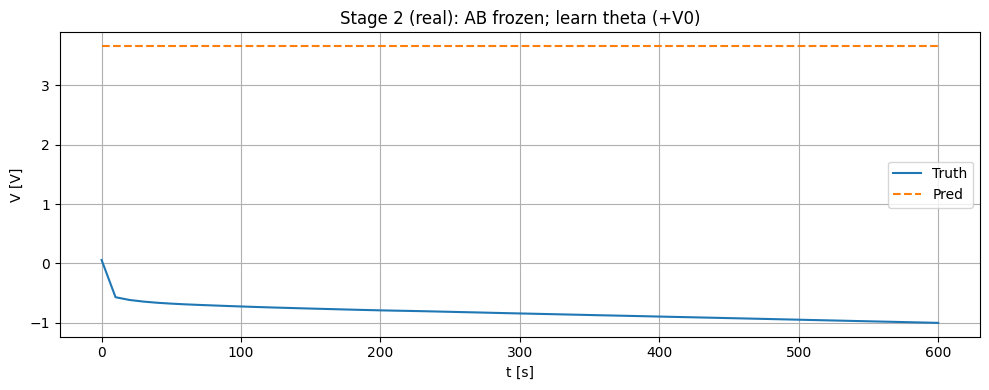

[Stage 2] theta_hat_raw: [ -0.07970858   0.07802856  -3.52341416 -13.74075109  -0.50867041]
[Stage 2] learned:
  Gamma_p: 0.923385
  Gamma_n: 1.08115
     K_e: 0.0294986
      R0: 1.07762e-06
      V0: -0.50867


In [10]:
# Run next after.. 


import jax
import jax.numpy as jnp
import diffrax
from jax_sysid.models import CTModel

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

DTYPE = jnp.float64

# --- A,B from physics assembly
_, A_np, B_np, _, _ = assemble_system(CFG)
A_fix = jnp.array(A_np, dtype=DTYPE)
B_fix = jnp.array(B_np, dtype=DTYPE)

# --- fixed ohmic contribution from model structure
R_fixed = float(CFG.R_ohm + electrolyte_resistance(CFG) + film_resistance(CFG))

# --- JAX OCVs
@jax.jit
def ocp_p_jax(xp):
    xp = jnp.clip(xp, 1e-9, 1 - 1e-9)
    return 4.15 - 0.12 * jnp.tanh((xp - 0.60) / 0.08)

@jax.jit
def ocp_n_jax(xn):
    xn = jnp.clip(xn, 1e-9, 1 - 1e-9)
    return 0.10 + 0.80 * (1.0 / (1.0 + jnp.exp(-(xn - 0.50) / 0.04)))

USE_V0 = True

def theta_map_stage2(raw_theta: jnp.ndarray) -> dict:
    Gamma_p = jnp.exp(raw_theta[0])
    Gamma_n = jnp.exp(raw_theta[1])
    K_e     = jnp.exp(raw_theta[2])
    R0      = jnp.exp(raw_theta[3])
    V0      = raw_theta[4] if USE_V0 else DTYPE(0.0)

    return dict(
        csn_max=DTYPE(CFG.csn_max),
        csp_max=DTYPE(CFG.csp_max),
        Gamma_p=Gamma_p,
        Gamma_n=Gamma_n,
        K_e=K_e,
        R0=R0,
        V0=V0,
    )

def voltage_from_params_stage2(x, I, p: dict):
    xp = jnp.clip(x[IDX["cp_surf"]] / p["csp_max"], 1e-9, 1 - 1e-9)
    xn = jnp.clip(x[IDX["cn_surf"]] / p["csn_max"], 1e-9, 1 - 1e-9)

    Up = ocp_p_jax(xp)
    Un = ocp_n_jax(xn)

    ceL_raw = x[IDX["ce_left"]]
    ceR_raw = x[IDX["ce_right"]]
    ceL = (DTYPE(CFG.ce0) + ceL_raw) if CFG.ce_is_deviation else ceL_raw
    ceR = (DTYPE(CFG.ce0) + ceR_raw) if CFG.ce_is_deviation else ceR_raw
    ceL = jnp.maximum(ceL, 1e-12)
    ceR = jnp.maximum(ceR, 1e-12)
    ce_avg = jnp.clip(0.5 * (ceL + ceR), 1e-12, 1e12)

    xp_eff = jnp.clip(xp, CFG.theta_guard, 1.0 - CFG.theta_guard)
    xn_eff = jnp.clip(xn, CFG.theta_guard, 1.0 - CFG.theta_guard)

    denom_p = p["Gamma_p"] * jnp.sqrt(ce_avg) * jnp.sqrt(xp_eff * (1 - xp_eff)) + 1e-18
    denom_n = p["Gamma_n"] * jnp.sqrt(ce_avg) * jnp.sqrt(xn_eff * (1 - xn_eff)) + 1e-18

    kappa = (2.0 * DTYPE(CFG.R) * DTYPE(CFG.T) / DTYPE(CFG.F))
    eta_p = DTYPE(CFG.bv_scale) * kappa * jnp.arcsinh(I / (2.0 * denom_p))
    eta_n = DTYPE(CFG.bv_scale) * kappa * jnp.arcsinh(I / (2.0 * denom_n))
    eta_combo = (eta_p - eta_n) if (CFG.eta_mode == "diff") else (eta_p + eta_n)

    ln_arg = (ceR / ceL) if (CFG.ln_orientation == "right_over_left") else (ceL / ceR)
    dphi_e = p["K_e"] * jnp.log(jnp.maximum(ln_arg, 1e-12))

    ohmic = -I * (DTYPE(R_fixed) + p["R0"])
    V_cell = (Up - Un) + eta_combo + dphi_e + ohmic

    V = DTYPE(CFG.N_series) * V_cell + p["V0"]
    return V

@jax.jit
def state_fcn_stage2(x, u, t, params):
    (raw_theta,) = params
    I = u[0]
    return A_fix @ x + (B_fix[:, 0] * I)

@jax.jit
def output_fcn_stage2(x, u, t, params):
    (raw_theta,) = params
    p = theta_map_stage2(raw_theta)
    I = u[0]
    V = voltage_from_params_stage2(x, I, p)
    return jnp.array([V], dtype=DTYPE)

# x0 init
x0_init = make_x0(CFG, theta_n0=0.6, theta_p0=0.6, ce0=0.0)

# theta0 init
Ke_phys = (2.0 * CFG.R * CFG.T / CFG.F) * (1.0 - CFG.t_plus) * CFG.k_f
Gamma_p0 = 1.0
Gamma_n0 = 1.0

theta0_list = [np.log(Gamma_p0), np.log(Gamma_n0), np.log(Ke_phys), np.log(1e-6)]
if USE_V0:
    theta0_list.append(0.0)
theta0_raw = np.array(theta0_list, dtype=np.float64)

model2 = CTModel(14, 1, 1, state_fcn=state_fcn_stage2, output_fcn=output_fcn_stage2)
model2.init(params=[theta0_raw], x0=np.array(x0_init, dtype=np.float64))

rho_x0 = 1e6
rho_th = 1e-8

try:
    model2.loss(rho_x0=rho_x0, rho_th=rho_th, xsat=1e9)
except TypeError:
    model2.loss(rho_x0=rho_x0, rho_th=rho_th)

model2.optimization(adam_epochs=80, lbfgs_epochs=10, adam_eta=1e-3)

# dt0 safety
if len(t_np) < 2:
    raise ValueError("Need at least 2 time points after filtering.")
dt0 = float(t_np[1] - t_np[0]) / 50.0

model2.integration_options(
    ode_solver=diffrax.Tsit5(),
    dt0=dt0,
    max_steps=200_000,
    stepsize_controller=diffrax.PIDController(rtol=1e-5, atol=1e-8),
)

Y0, _ = model2.predict(model2.x0, U_np, t_np)
print("[Stage 2] pre-fit max|err|:", float(np.max(np.abs(np.asarray(Y0) - Y_np))))

model2.fit(Y_np, U_np, t_np)
Yhat2, _ = model2.predict(model2.x0, U_np, t_np)

plot_voltage(t_np, Y_np, np.asarray(Yhat2), title="Stage 2 (real): AB frozen; learn theta (+V0)")

theta_hat = np.asarray(model2.params[0]).copy()
print("[Stage 2] theta_hat_raw:", theta_hat)

p2 = theta_map_stage2(jnp.array(theta_hat, dtype=DTYPE))
print("[Stage 2] learned:")
for k in ["Gamma_p","Gamma_n","K_e","R0","V0"]:
    if k in p2:
        print(f"  {k:>6s}: {float(p2[k]):.6g}")


[Stage 3] pre-fit max|err|: 4.662623796120098


  0%|                        |

Solving NLP with Adam (20 optimization variables) ...


100%|████████████████████████|
    f =  20.175425, f* =  20.173947, |grad f| =  91.767774, iter = 80


Solving NLP with L-BFGS (20 optimization variables) ...
L-BFGS-B done in 2 iterations.


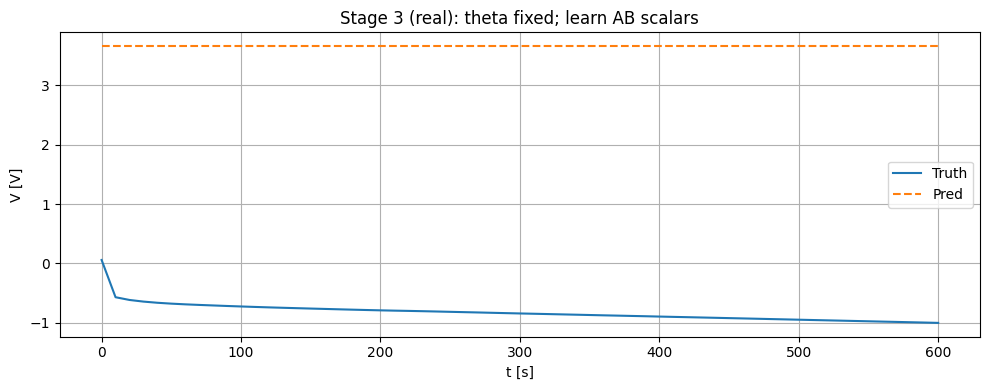

[Stage 3] learned AB scalars:
  sDn: 1
  sDp: 1.00001
  sDe: 1.00006
   gn: 1
   gp: 0.999988
   ge: 0.999936


In [11]:
import jax
import jax.numpy as jnp
import diffrax
from jax_sysid.models import CTModel
import numpy as np

DTYPE = jnp.float64

# Base blocks
_, _, _, (An_np, Ap_np, Ae_np, Bn_np, Bp_np, Be_np), _ = assemble_system(CFG)
An0 = jnp.array(An_np, dtype=DTYPE)
Ap0 = jnp.array(Ap_np, dtype=DTYPE)
Ae0 = jnp.array(Ae_np, dtype=DTYPE)
Bn0 = jnp.array(Bn_np, dtype=DTYPE)
Bp0 = jnp.array(Bp_np, dtype=DTYPE)
Be0 = jnp.array(Be_np, dtype=DTYPE)

def block_diag_jax(A, B, C):
    z1 = jnp.zeros((A.shape[0], B.shape[1]), dtype=A.dtype)
    z2 = jnp.zeros((A.shape[0], C.shape[1]), dtype=A.dtype)
    z3 = jnp.zeros((B.shape[0], A.shape[1]), dtype=A.dtype)
    z4 = jnp.zeros((B.shape[0], C.shape[1]), dtype=A.dtype)
    z5 = jnp.zeros((C.shape[0], A.shape[1]), dtype=A.dtype)
    z6 = jnp.zeros((C.shape[0], B.shape[1]), dtype=A.dtype)
    top = jnp.concatenate([A, z1, z2], axis=1)
    mid = jnp.concatenate([z3, B, z4], axis=1)
    bot = jnp.concatenate([z5, z6, C], axis=1)
    return jnp.concatenate([top, mid, bot], axis=0)

def ab_map(raw_ab: jnp.ndarray) -> dict:
    return dict(
        sDn=jnp.exp(raw_ab[0]),
        sDp=jnp.exp(raw_ab[1]),
        sDe=jnp.exp(raw_ab[2]),
        gn=jnp.exp(raw_ab[3]),
        gp=jnp.exp(raw_ab[4]),
        ge=jnp.exp(raw_ab[5]),
    )

def build_AB_from_ab(raw_ab: jnp.ndarray):
    ab = ab_map(raw_ab)
    A = block_diag_jax(ab["sDn"]*An0, ab["sDp"]*Ap0, ab["sDe"]*Ae0)
    B = jnp.concatenate([ab["gn"]*Bn0, ab["gp"]*Bp0, ab["ge"]*Be0], axis=0)
    return A, B

theta_fixed = np.asarray(theta_hat).copy()

def theta_map_fixed():
    return theta_map_stage2(jnp.array(theta_fixed, dtype=DTYPE))

@jax.jit
def state_fcn_stage3(x, u, t, params):
    (raw_ab,) = params
    A, B = build_AB_from_ab(raw_ab)
    I = u[0]
    return A @ x + (B[:, 0] * I)

@jax.jit
def output_fcn_stage3(x, u, t, params):
    (raw_ab,) = params
    p = theta_map_fixed()
    I = u[0]
    V = voltage_from_params_stage2(x, I, p)
    return jnp.array([V], dtype=DTYPE)

raw_ab0 = np.zeros(6, dtype=np.float64)

m3 = CTModel(14, 1, 1, state_fcn=state_fcn_stage3, output_fcn=output_fcn_stage3)

x0_for_stage3 = np.array(model2.x0, dtype=np.float64)
m3.init(params=[raw_ab0], x0=x0_for_stage3)

rho_x0 = 1e6
rho_th = 1e-2

try:
    m3.loss(rho_x0=rho_x0, rho_th=rho_th, xsat=1e9)
except TypeError:
    m3.loss(rho_x0=rho_x0, rho_th=rho_th)

m3.optimization(adam_epochs=80, lbfgs_epochs=10, adam_eta=1e-3)

dt0 = float(t_np[1] - t_np[0]) / 50.0
m3.integration_options(
    ode_solver=diffrax.Tsit5(),
    dt0=dt0,
    max_steps=200_000,
    stepsize_controller=diffrax.PIDController(rtol=1e-5, atol=1e-8),
)

Y0, _ = m3.predict(m3.x0, U_np, t_np)
print("[Stage 3] pre-fit max|err|:", float(np.max(np.abs(np.asarray(Y0) - Y_np))))

m3.fit(Y_np, U_np, t_np)
Yhat3, _ = m3.predict(m3.x0, U_np, t_np)

plot_voltage(t_np, Y_np, np.asarray(Yhat3), title="Stage 3 (real): theta fixed; learn AB scalars")

raw_ab_hat = np.asarray(m3.params[0])
ab_hat = ab_map(jnp.array(raw_ab_hat, dtype=DTYPE))
print("[Stage 3] learned AB scalars:")
for k in ["sDn","sDp","sDe","gn","gp","ge"]:
    print(f"  {k:>3s}: {float(ab_hat[k]):.6g}")


In [12]:
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import diffrax
from jax_sysid.models import CTModel

DTYPE = jnp.float64

# -----------------------------
# Pack raw params: [raw_theta(4 + optional V0 baked into theta_map_stage2) ?]
# We already use USE_V0=True in stage2 mapping, so raw_theta is length 5.
# But Stage 4 wants: raw_theta(5) + raw_ab(6) => 11 params total
# -----------------------------

if not USE_V0:
    raise ValueError("Stage 4 here assumes USE_V0=True (raw_theta length 5).")

def unpack_stage4_real(raw: jnp.ndarray):
    raw_theta = raw[:5]      # Gamma_p, Gamma_n, K_e, R0, V0
    raw_ab    = raw[5:11]    # 6 scalars
    return raw_theta, raw_ab

@jax.jit
def state_fcn_stage4_real(x, u, t, params):
    (raw,) = params
    _, raw_ab = unpack_stage4_real(raw)
    A, B = build_AB_from_ab(raw_ab)
    I = u[0]
    return A @ x + (B[:, 0] * I)

@jax.jit
def output_fcn_stage4_real(x, u, t, params):
    (raw,) = params
    raw_theta, _ = unpack_stage4_real(raw)
    p = theta_map_stage2(raw_theta)
    I = u[0]
    V = voltage_from_params_stage2(x, I, p)
    return jnp.array([V], dtype=DTYPE)

def stage4_real_init_raw(
    rng: np.random.Generator,
    theta_center_raw: np.ndarray,
    ab_lo=0.90,
    ab_hi=1.10,
    theta_sigma=0.10,
) -> np.ndarray:
    """
    raw_theta ~ N(theta_center_raw, theta_sigma^2)
    raw_ab    ~ Uniform(log(ab_lo), log(ab_hi))
    """
    raw_theta0 = theta_center_raw + rng.normal(0.0, theta_sigma, size=(5,))
    raw_ab0 = rng.uniform(np.log(ab_lo), np.log(ab_hi), size=(6,))
    return np.concatenate([raw_theta0, raw_ab0]).astype(np.float64)

def run_stage4_real_once(
    raw_init: np.ndarray,
    x0_init: np.ndarray,
    t_np: np.ndarray,
    U_np: np.ndarray,
    Y_np: np.ndarray,
    rho_x0: float = 0.0,     # FREE x0
    rho_th: float = 1e-8,
    adam_epochs: int = 80,
    lbfgs_epochs: int = 20,
    adam_eta: float = 1e-3,
    dt0_div: float = 20.0,
    max_steps: int = 200_000,
    rtol: float = 1e-5,
    atol: float = 1e-8,
):
    try:
        m4 = CTModel(14, 1, 1, state_fcn=state_fcn_stage4_real, output_fcn=output_fcn_stage4_real)
        m4.init(params=[raw_init.astype(np.float64)], x0=np.array(x0_init, dtype=np.float64))

        try:
            m4.loss(rho_x0=rho_x0, rho_th=rho_th, xsat=1e9)
        except TypeError:
            m4.loss(rho_x0=rho_x0, rho_th=rho_th)

        m4.optimization(adam_epochs=adam_epochs, lbfgs_epochs=lbfgs_epochs, adam_eta=adam_eta)

        dt0 = float(t_np[1] - t_np[0]) / float(dt0_div)
        m4.integration_options(
            ode_solver=diffrax.Tsit5(),
            dt0=dt0,
            max_steps=int(max_steps),
            stepsize_controller=diffrax.PIDController(rtol=rtol, atol=atol),
        )

        # prefit
        Y0, _ = m4.predict(m4.x0, U_np, t_np)
        pre_max = float(np.max(np.abs(np.asarray(Y0) - Y_np)))

        # fit
        m4.fit(Y_np, U_np, t_np)

        # postfit
        Yhat, _ = m4.predict(m4.x0, U_np, t_np)
        err = np.asarray(Yhat) - Y_np
        post_max = float(np.max(np.abs(err)))
        mse = float(np.mean(err**2))

        raw_final = np.asarray(m4.params[0])
        raw_theta_f, raw_ab_f = unpack_stage4_real(jnp.array(raw_final, dtype=DTYPE))
        p_f = theta_map_stage2(raw_theta_f)
        ab_f = ab_map(raw_ab_f)

        th = dict(
            Gamma_p=float(p_f["Gamma_p"]),
            Gamma_n=float(p_f["Gamma_n"]),
            K_e=float(p_f["K_e"]),
            R0=float(p_f["R0"]),
            V0=float(p_f["V0"]),
        )
        ab = {k: float(ab_f[k]) for k in ["sDn", "sDp", "sDe", "gn", "gp", "ge"]}

        met = dict(pre_max=pre_max, post_max=post_max, mse=mse, err="")
        ok = bool(np.isfinite(mse) and np.isfinite(post_max))
        return ok, m4, np.asarray(Yhat), met, th, ab, raw_final

    except Exception as e:
        met = dict(pre_max=np.inf, post_max=np.inf, mse=np.inf, err=repr(e))
        return False, None, None, met, {}, {}, None

def multistart_stage4_real(
    t_np: np.ndarray,
    U_np: np.ndarray,
    Y_np: np.ndarray,
    n_trials: int = 2,
    seed: int = 0,
    theta_center_raw: np.ndarray | None = None,
    ab_lo: float = 0.90,
    ab_hi: float = 1.10,
    theta_sigma: float = 0.10,
    x0_trials: int = 2,
    x0_theta_lo: float = 0.05,
    x0_theta_hi: float = 0.95,
    x0_ce0: float = 0.0,
    rho_x0: float = 0.0,
    rho_th: float = 1e-8,
    adam_epochs: int = 80,
    lbfgs_epochs: int = 20,
    adam_eta: float = 1e-3,
):
    if len(t_np) < 2:
        raise ValueError("Need at least 2 time points for stage 4.")
    rng = np.random.default_rng(seed)

    if theta_center_raw is None:
        # Use stage-2 solution as center if available
        theta_center_raw = np.asarray(theta_hat, dtype=np.float64)  # length 5 because USE_V0=True

    rows = []
    best = None

    for i in range(n_trials):
        raw0 = stage4_real_init_raw(
            rng=rng,
            theta_center_raw=theta_center_raw,
            ab_lo=ab_lo,
            ab_hi=ab_hi,
            theta_sigma=theta_sigma,
        )

        for j in range(max(1, x0_trials)):
            tn0 = rng.uniform(x0_theta_lo, x0_theta_hi)
            tp0 = rng.uniform(x0_theta_lo, x0_theta_hi)
            x0_init = make_x0(CFG, theta_n0=tn0, theta_p0=tp0, ce0=x0_ce0)

            ok, m4, Yhat, met, th, ab, _ = run_stage4_real_once(
                raw_init=raw0,
                x0_init=x0_init,
                t_np=t_np,
                U_np=U_np,
                Y_np=Y_np,
                rho_x0=rho_x0,
                rho_th=rho_th,
                adam_epochs=adam_epochs,
                lbfgs_epochs=lbfgs_epochs,
                adam_eta=adam_eta,
            )

            row = dict(
                trial=i,
                x0trial=j,
                ok_run=int(ok),
                pre_max=float(met["pre_max"]),
                post_max=float(met["post_max"]),
                mse=float(met["mse"]),
                err=str(met.get("err", "")),
                xn0=float(tn0),
                xp0=float(tp0),
                **(th if th else {}),
                **(ab if ab else {}),
            )
            rows.append(row)

            if ok and ((best is None) or (met["mse"] < best["metrics"]["mse"])):
                best = dict(m4=m4, Yhat=Yhat, metrics=met, theta=th, ab=ab, x0=x0_init)

    df = pd.DataFrame(rows).sort_values("mse").reset_index(drop=True)

    summary = dict(
        total_configs=int(len(df)),
        runs_completed=int(df["ok_run"].sum()) if len(df) else 0,
        best_mse=float(df.iloc[0]["mse"]) if len(df) else np.inf,
        best_post_max=float(df.iloc[0]["post_max"]) if len(df) else np.inf,
    )

    print("\n=== Stage 4 REAL multistart summary ===")
    print(summary)
    print("\nTop 5 by MSE:")
    print(df.head(5).to_string(index=False))

    return best, df, summary

# ---- RUN STAGE 4 using the already-filtered t_np, U_np, Y_np
best, df, summ = multistart_stage4_real(
    t_np=t_np,
    U_np=U_np,
    Y_np=Y_np,
    n_trials=10,
    seed=0,
    theta_center_raw=np.asarray(theta_hat, dtype=np.float64),  # center around stage2 solution
    x0_trials=8,
    adam_epochs=800,
    lbfgs_epochs=150,
)

if best is not None:
    plot_voltage(t_np, Y_np, best["Yhat"], title="Stage 4 REAL: best (free-x0 + theta + AB)")
    print("\nBest metrics:", best["metrics"])
    print("Best theta:", best["theta"])
    print("Best ab:", best["ab"])


  0%|                        |

Solving NLP with Adam (25 optimization variables) ...


100%|████████████████████████|
    f =  11.662116, f* =  11.662116, |grad f| =  6.824904, iter = 800


Solving NLP with L-BFGS (25 optimization variables) ...


ERROR:2026-01-21 19:19:17,713:jax._src.callback:94: jax.pure_callback failed
Traceback (most recent call last):
  File "c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\venvmain\Lib\site-packages\jax\_src\callback.py", line 92, in pure_callback_impl
    return tree_util.tree_map(np.asarray, callback(*args))
                                          ^^^^^^^^^^^^^^^
  File "c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\venvmain\Lib\site-packages\jax\_src\callback.py", line 70, in __call__
    return tree_util.tree_leaves(self.callback_func(*args, **kwargs))
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\venvmain\Lib\site-packages\equinox\_errors.py", line 88, in raises
    raise _EquinoxRuntimeError(
equinox._errors._EquinoxRuntimeError: The maximum number of solver steps was reached. Try increasing `max_steps`.


-------------

Solving NLP with Adam (25 optimization variables) ...


 85%|████████████████████▍   |

KeyboardInterrupt: 